### Imports

In [1]:
import numpy as np
import pandas as pd
import math
import requests
from numpy import nan
import re
from sklearn import preprocessing
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

### File reading

In [2]:
data = pd.read_csv('./raw_dataset_houses.csv', index_col = 0)
data = data.drop(['Dostępne od', 'Media', 'Obsługa zdalna', 'Typ ogłoszeniodawcy', 'Materiał budynku', 'Ilość pokoi', 'Dach', 'Pokrycie dachu', 'Położenie', 'Dojazd', 'Poddasze', 'Okna', 'Ogrzewanie', 'Ogrodzenie'], axis = 1)

In [3]:
data.rename(columns = {'Cena': 'price', 'Cena za metr kwadratowy': 'price_per_square_meter', 'Powierzchnia': 'area', 'Lokalizacja': 'location', 'Liczba pokoi': 'number_of_rooms', 'Stan wykończenia': 'finishing_standard', 'Liczba pięter': 'number_of_floors', 'Czynsz': 'rent', 'Miejsce parkingowe': 'parking', 'Ogrzewanie': 'heating', 'Rynek': 'market', 'Rok budowy': 'construction_year', 'Rodzaj zabudowy': 'building_type', 'Winda': 'lift', 'Zabezpieczenia': 'security', 'Informacje dodatkowe': 'additional_information', 'Dom rekreacyjny': 'summer_house', 'Okolica': 'surroundings', 'Powierzchnia działki': 'land_area'}, inplace=True)

In [4]:
data = data.reset_index(drop = True)

In [5]:
data.head()

,price,price_per_square_meter,area,location,land_area,finishing_standard,building_type,construction_year,number_of_rooms,parking,rent,market,number_of_floors,summer_house,security,surroundings,additional_information
0,80 000 zł,1143 zł/m2,70 m²,"Piszewo, warmińsko-mazurskie",806 m²,do remontu,wolnostojący,1930,3,Zapytaj,Zapytaj,wtórny,1 piętro,brak informacji,brak informacji,brak informacji,brak informacji
1,369 000 zł,858 zł/m2,430 m²,"Dworcowa, Grabów, łódzkie",7400 m²,do remontu,Zapytaj,Zapytaj,9,Zapytaj,Zapytaj,wtórny,brak informacji,brak informacji,brak informacji,brak informacji,brak informacji
2,800 000 zł,2000 zł/m2,400 m²,"Mońki, moniecki, podlaskie",1500 m²,do zamieszkania,wolnostojący,1982,7,Zapytaj,Zapytaj,wtórny,2 piętra,brak informacji,brak informacji,brak informacji,brak informacji
3,849 600 zł,1770 zł/m2,480 m²,"Mrągowo, warmińsko-mazurskie",2300 m²,do zamieszkania,wolnostojący,Zapytaj,więcej niż 10,garaż,Zapytaj,wtórny,brak informacji,brak informacji,"drzwi / okna antywłamaniowe, rolety antywłaman...","las, jezioro","strych, piwnica"
4,395 000 zł,3292 zł/m2,120 m²,"Brzesko, brzeski, małopolskie",300 m²,do remontu,Zapytaj,Zapytaj,3,garaż,Zapytaj,wtórny,1 piętro,brak informacji,brak informacji,brak informacji,brak informacji


In [6]:
data.describe()

,price,price_per_square_meter,area,location,land_area,finishing_standard,building_type,construction_year,number_of_rooms,parking,rent,market,number_of_floors,summer_house,security,surroundings,additional_information
count,47651,46963,47651,47651,47598,47598,47598,47598,47598,47598,47598,46979,46979,46979,46979,46979,46979
unique,3136,9952,7654,19690,5366,6,9,241,11,2,124,2,5,2,64,14,30
top,699 000 zł,5000 zł/m2,120 m²,"Grodzisk Mazowiecki, mazowieckie",Zapytaj,do zamieszkania,wolnostojący,2022,4,garaż,Zapytaj,wtórny,1 piętro,brak informacji,brak informacji,brak informacji,brak informacji
freq,754,290,1091,261,2153,16817,24246,10407,14471,27851,46762,31775,23525,46454,30372,35030,33664


In [7]:
def get_address_details(location):
    location = re.sub(r'\w*\.\w*', '', location).strip()
    r = requests.get(f'https://nominatim.openstreetmap.org/search/{location}?format=json&addressdetails=1')
    if(bool(r.json())):
        result = r.json()[0]
        address_details = result['address']
        return {'latitude': result['lat'], 'longtitude': result['lon'], 'city': address_details.get('city', nan), 'state': address_details.get('state', nan), 'village': address_details.get('village', nan), 'town': address_details.get('town', nan), 'road': address_details.get('road', nan), 'city_district': address_details.get('city_district', nan)}


def get_population(locality):
    r = requests.get(f'https://public.opendatasoft.com/api/records/1.0/search/?dataset=geonames-all-cities-with-a-population-1000&q={locality}')
    if(locality.lower() == 'Warszawa'.lower()):
        return 1765000
    if(bool(r.json().get('records'))):
        return r.json().get('records')[0].get('fields').get('population')

In [8]:
def get_time_to_nearest_point(point_type, lat, lon):
    result = requests.get(f'https://nominatim.openstreetmap.org/search.php?q={point_type}+near+{lat},{lon}&format=jsonv2&limit=1').json()
    if(bool(result)):
        point_lat = result[0].get('lat')
        point_lon = result[0].get('lon')
        duration_res = requests.get(f'https://router.project-osrm.org/route/v1/car/{lon},{lat};{point_lon},{point_lat}?overview=false').json()
        if(bool(duration_res and bool(duration_res.get('routes')))):
            duration = duration_res.get('routes')[0].get('duration') 
            return duration / 60 #convert to minutes

def get_time_to_nearest_shop(lat, lon):
    time_to_nearest_supermarket = get_time_to_nearest_point('supermarket', lat, lon)
    time_to_nearest_convenience_shop = get_time_to_nearest_point('convenience_shop', lat, lon)
    
    result = min(time_to_nearest_supermarket or 100000, time_to_nearest_convenience_shop or 100000)
    
    if(result != 100000):
        return result

def get_time_to_nearest_stop(lat, lon):
    time_to_nearest_bus_stop = get_time_to_nearest_point('bus stop', lat, lon)
    time_to_nearest_tram_stop = get_time_to_nearest_point('tram stop', lat, lon)
    
    result = min(time_to_nearest_bus_stop or 100000, time_to_nearest_tram_stop or 100000) 
    
    if(result != 100000):
        return result

def get_time_to_centre(lat, lon, location):
    result = requests.get(f'https://nominatim.openstreetmap.org/search/{location}?format=json&addressdetails=1').json()
    if(bool(result)):
        centre_lat = result[0].get('lat')
        centre_lon = result[0].get('lon')
        duration_res = requests.get(f'https://router.project-osrm.org/route/v1/car/{lon},{lat};{centre_lon},{centre_lat}?overview=false').json()
        if(bool(duration_res) and bool(duration_res.get('routes'))):
            duration = duration_res.get('routes')[0].get('duration')  
            return duration / 60 #convert to minutes

In [9]:
data = data.fillna(nan)
data = data.replace({'zapytaj': nan, "Zapytaj o cenę": nan, "brak informacji": nan})

In [10]:
for index, row in data.iterrows():
    if(data.loc[index, 'price'] is nan or (data.loc[index, 'price'] is not nan and '€' in data.loc[index, 'price'])):
        data = data.drop(index)

In [11]:
data = data.reset_index(drop = True)

In [12]:
for index, row in data.iterrows():
    row = row.copy()
    location = row.location 
    dict_temp = get_address_details(location)
    if(bool(dict_temp)):
        data.loc[index, 'state'] = dict_temp.get('state')

        if(isinstance(dict_temp.get('city'), str)):
            data.loc[index, 'locality'] = dict_temp.get('city')
            data.loc[index, 'population'] = get_population(dict_temp.get('city'))
            data.loc[index, 'type_of_locality'] = 'city'
        if(isinstance(dict_temp.get('village'), str)):
            data.loc[index, 'locality'] = dict_temp.get('village')
            data.loc[index, 'population'] = get_population(dict_temp.get('village'))
            data.loc[index, 'type_of_locality'] = 'village'
        if(isinstance(dict_temp.get('town'), str)):
            data.loc[index, 'locality'] = dict_temp.get('town')
            data.loc[index, 'population'] = get_population(dict_temp.get('town'))
            data.loc[index, 'type_of_locality'] = 'town'

        latitude = dict_temp.get('latitude')
        longtitude = dict_temp.get('longtitude')
        locality = data.iloc[index]['locality']
        data.loc[index, 'time_to_nearest_shop'] = get_time_to_nearest_shop(latitude, longtitude)
        data.loc[index, 'time_to_nearest_stop'] = get_time_to_nearest_stop(latitude, longtitude)
        data.loc[index, 'time_to_centre'] = get_time_to_centre(latitude, longtitude, locality)

In [13]:
data = data.fillna(nan)

In [14]:
data.to_csv('./enriched_dataset_houses.csv')

In [15]:
data = pd.read_csv('./enriched_dataset_houses.csv', index_col = 0)
data.head()

,price,price_per_square_meter,area,location,heating,land_area,finishing_standard,building_type,construction_year,number_of_rooms,...,security,surroundings,additional_information,state,locality,population,type_of_locality,time_to_nearest_shop,time_to_nearest_stop,time_to_centre
0,80 000 zł,1143 zł/m2,70 m²,"Piszewo, warmińsko-mazurskie",Zapytaj,806 m²,do remontu,wolnostojący,1930,3,...,NaN,NaN,NaN,województwo warmińsko-mazurskie,Piszewo,NaN,village,8.630000,12.511667,0.000000
1,369 000 zł,858 zł/m2,430 m²,"Dworcowa, Grabów, łódzkie",Zapytaj,7400 m²,do remontu,Zapytaj,Zapytaj,9,...,NaN,NaN,NaN,województwo łódzkie,Grabów,922.0,village,1.875000,3.788333,65.848333
2,800 000 zł,2000 zł/m2,400 m²,"Mońki, moniecki, podlaskie",olejowe,1500 m²,do zamieszkania,wolnostojący,1982,7,...,NaN,NaN,NaN,województwo podlaskie,Mońki,10577.0,town,1.030000,NaN,0.000000
3,849 600 zł,1770 zł/m2,480 m²,"Mrągowo, warmińsko-mazurskie",biomasa,2300 m²,do zamieszkania,wolnostojący,Zapytaj,więcej niż 10,...,"drzwi / okna antywłamaniowe, rolety antywłaman...","las, jezioro","strych, piwnica",województwo warmińsko-mazurskie,Mrągowo,21965.0,town,1.753333,0.870000,0.000000
4,395 000 zł,3292 zł/m2,120 m²,"Brzesko, brzeski, małopolskie",Zapytaj,300 m²,do remontu,Zapytaj,Zapytaj,3,...,NaN,NaN,NaN,województwo małopolskie,Brzesko,16866.0,town,2.688333,0.830000,0.000000


In [16]:
data.columns

Index(['price', 'price_per_square_meter', 'area', 'location', 'heating',
       'land_area', 'finishing_standard', 'building_type', 'construction_year',
       'number_of_rooms', 'parking', 'rent', 'market', 'number_of_floors',
       'summer_house', 'security', 'surroundings', 'additional_information',
       'state', 'locality', 'population', 'type_of_locality',
       'time_to_nearest_shop', 'time_to_nearest_stop', 'time_to_centre'],
      dtype='object')

### Categorical columns

In [17]:
categorical_columns_names = ['finishing_standard', 'parking', 'market', 'building_type', 'security', 'additional_information', 'summer_house', 'surroundings']

In [18]:
for column_name in categorical_columns_names:
    print(column_name)
    print(data[column_name].unique())

finishing_standard
['do remontu' 'do zamieszkania' 'Zapytaj' 'do wykończenia'
 'stan surowy zamknięty' 'stan surowy otwarty' nan]
parking
['Zapytaj' 'garaż' nan]
market
['wtórny' 'pierwotny' nan]
building_type
['wolnostojący' 'Zapytaj' 'gospodarstwo' 'bliźniak' 'dworek/pałac'
 'kamienica' 'szeregowiec' nan 'dom wolnostojący'
 'frontend.ad.table-information-value-building_type-11-block']
security
[nan 'drzwi / okna antywłamaniowe, rolety antywłamaniowe'
 'system alarmowy, monitoring / ochrona' 'system alarmowy'
 'teren zamknięty'
 'system alarmowy, teren zamknięty, monitoring / ochrona'
 'drzwi / okna antywłamaniowe'
 'drzwi / okna antywłamaniowe, teren zamknięty'
 'system alarmowy, domofon / wideofon'
 'drzwi / okna antywłamaniowe, teren zamknięty, rolety antywłamaniowe'
 'domofon / wideofon, rolety antywłamaniowe'
 'system alarmowy, drzwi / okna antywłamaniowe, teren zamknięty, domofon / wideofon, monitoring / ochrona'
 'domofon / wideofon, monitoring / ochrona' 'monitoring / ochrona'

In [19]:
le_finishing_standard = preprocessing.LabelEncoder()
le_finishing_standard.fit(data['finishing_standard'])
print(list(le_finishing_standard.classes_))
data['finishing_standard'] = le_finishing_standard.fit_transform(data['finishing_standard'])

le_heating = preprocessing.LabelEncoder()
le_heating.fit(data['heating'])
print(list(le_heating.classes_))
data['heating'] = le_heating.fit_transform(data['heating'])

le_building_type = preprocessing.LabelEncoder()
le_building_type.fit(data['building_type'])
print(list(le_building_type.classes_))
data['building_type'] = le_building_type.fit_transform(data['building_type'])

le_market = preprocessing.LabelEncoder()
le_market.fit(data['market'])
print(list(le_market.classes_))
data['market'] = le_market.fit_transform(data['market'])

le_state = preprocessing.LabelEncoder()
le_state.fit(data['state'])
print(list(le_state.classes_))
data['state'] = le_state.fit_transform(data['state'])

le_locality = preprocessing.LabelEncoder()
le_locality.fit(data['locality'])
print(list(le_locality.classes_))
data['locality'] = le_locality.fit_transform(data['locality'])

le_locality_type = preprocessing.LabelEncoder()
le_locality_type.fit(data['type_of_locality'])
print(list(le_locality_type.classes_))
data['type_of_locality'] = le_locality_type.fit_transform(data['type_of_locality'])

['Zapytaj', 'do remontu', 'do wykończenia', 'do zamieszkania', 'stan surowy otwarty', 'stan surowy zamknięty', nan]
['Zapytaj', 'biomasa', 'biomasa, elektryczne, kominkowe', 'biomasa, elektryczne, kominkowe, gazowe, pompa ciepła, olejowe', 'biomasa, elektryczne, kominkowe, gazowe, pompa ciepła, olejowe, kolektor słoneczny', 'biomasa, elektryczne, pompa ciepła, olejowe', 'biomasa, gazowe', 'biomasa, gazowe, miejskie', 'biomasa, gazowe, pompa ciepła', 'biomasa, kolektor słoneczny', 'biomasa, kominkowe', 'biomasa, kominkowe, gazowe', 'biomasa, kominkowe, gazowe, olejowe, kolektor słoneczny', 'biomasa, kominkowe, gazowe, pompa ciepła', 'biomasa, kominkowe, olejowe', 'biomasa, kominkowe, piece kaflowe', 'biomasa, kominkowe, pompa ciepła', 'biomasa, olejowe', 'biomasa, piece kaflowe', 'biomasa, pompa ciepła', 'biomasa, węglowe', 'biomasa, węglowe, elektryczne, kominkowe', 'biomasa, węglowe, elektryczne, kominkowe, gazowe', 'biomasa, węglowe, elektryczne, kominkowe, gazowe, geotermika, pompa 

['city', 'town', 'village', nan]


In [20]:
data = data.assign(
    is_lake = data['surroundings'].fillna('nan').apply(lambda x: ('jezioro' in x)).astype(int),
    is_forest = data['surroundings'].fillna('nan').apply(lambda x: ('las' in x)).astype(int),
    is_moutain = data['surroundings'].fillna('nan').apply(lambda x: ('góry' in x)).astype(int),
    is_sea = data['surroundings'].fillna('nan').apply(lambda x: ('morze' in x)).astype(int),
    has_parking = (~data.parking.isna()).astype(int),
    is_summer_house = (~data.summer_house.isna()).astype(int),
    has_security_protection = (~data.security.isna()).astype(int),
    is_duplex = data['additional_information'].fillna('nan').apply(lambda x: ('dwupoziomowe' in x)).astype(int),
    has_basement = data['additional_information'].fillna('nan').apply(lambda x: ('piwnica' in x)).astype(int))

In [21]:
data.head()

,price,price_per_square_meter,area,location,heating,land_area,finishing_standard,building_type,construction_year,number_of_rooms,...,time_to_centre,is_lake,is_forest,is_moutain,is_sea,has_parking,is_summer_house,has_security_protection,is_duplex,has_basement
0,80 000 zł,1143 zł/m2,70 m²,"Piszewo, warmińsko-mazurskie",0,806 m²,1,8,1930,3,...,0.000000,0,0,0,0,1,0,0,0,0
1,369 000 zł,858 zł/m2,430 m²,"Dworcowa, Grabów, łódzkie",0,7400 m²,1,0,Zapytaj,9,...,65.848333,0,0,0,0,1,0,0,0,0
2,800 000 zł,2000 zł/m2,400 m²,"Mońki, moniecki, podlaskie",111,1500 m²,3,8,1982,7,...,0.000000,0,0,0,0,1,0,0,0,0
3,849 600 zł,1770 zł/m2,480 m²,"Mrągowo, warmińsko-mazurskie",1,2300 m²,3,8,Zapytaj,więcej niż 10,...,0.000000,1,1,0,0,1,0,1,0,1
4,395 000 zł,3292 zł/m2,120 m²,"Brzesko, brzeski, małopolskie",0,300 m²,1,0,Zapytaj,3,...,0.000000,0,0,0,0,1,0,0,0,0


### Numerical columns

In [22]:
data = data[data['price'].str.contains("zł", na = False)]
data

,price,price_per_square_meter,area,location,heating,land_area,finishing_standard,building_type,construction_year,number_of_rooms,...,time_to_centre,is_lake,is_forest,is_moutain,is_sea,has_parking,is_summer_house,has_security_protection,is_duplex,has_basement
0,80 000 zł,1143 zł/m2,70 m²,"Piszewo, warmińsko-mazurskie",0,806 m²,1,8,1930,3,...,0.000000,0,0,0,0,1,0,0,0,0
1,369 000 zł,858 zł/m2,430 m²,"Dworcowa, Grabów, łódzkie",0,7400 m²,1,0,Zapytaj,9,...,65.848333,0,0,0,0,1,0,0,0,0
2,800 000 zł,2000 zł/m2,400 m²,"Mońki, moniecki, podlaskie",111,1500 m²,3,8,1982,7,...,0.000000,0,0,0,0,1,0,0,0,0
3,849 600 zł,1770 zł/m2,480 m²,"Mrągowo, warmińsko-mazurskie",1,2300 m²,3,8,Zapytaj,więcej niż 10,...,0.000000,1,1,0,0,1,0,1,0,1
4,395 000 zł,3292 zł/m2,120 m²,"Brzesko, brzeski, małopolskie",0,300 m²,1,0,Zapytaj,3,...,0.000000,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47646,1 300 000 zł,5306 zł/m2,245 m²,"Warszawa, Wawer, Radość",70,300 m²,3,0,1990,6,...,22.916667,0,0,0,0,1,0,0,0,0
47647,461 000 zł,6183 zł/m2,"74,56 m²","Czapury, wielkopolskie",0,Zapytaj,2,0,2022,4,...,0.000000,0,0,0,0,1,0,0,0,0
47648,770 000 zł,5923 zł/m2,130 m²,"Milanówek, mazowieckie",110,346 m²,2,1,2022,5,...,0.000000,0,0,0,0,1,0,1,0,0
47649,739 000 zł,5503 zł/m2,"134,28 m²","Bydgoszcz, Osowa Góra",70,355 m²,2,0,2022,5,...,14.493333,0,0,0,0,1,0,0,0,0


In [23]:
data_without_m2_value = data[~data["area"].str.contains("m²", na = True)]
data_without_m2_value = data_without_m2_value[~data_without_m2_value["area"].str.contains("m2", na = True)]

data_without_m2_value

,price,price_per_square_meter,area,location,heating,land_area,finishing_standard,building_type,construction_year,number_of_rooms,...,time_to_centre,is_lake,is_forest,is_moutain,is_sea,has_parking,is_summer_house,has_security_protection,is_duplex,has_basement


In [24]:
float_columns_names = ['price', 'price_per_square_meter', 'area', 'rent', 'land_area']
int_columns_names = ['number_of_rooms', 'construction_year']
numerical_columns_names = float_columns_names + int_columns_names
for column_name in numerical_columns_names:
    if column_name in float_columns_names: 
        data[column_name] = data[column_name].str.replace(' ', '').str.replace(',', '.').str.extract('(\d+\.*\d+)').astype(float)
    else: 
        data[column_name] = pd.to_numeric(data[column_name], errors='coerce').convert_dtypes()

In [25]:
data['number_of_floors'] = data['number_of_floors'].str.extract('(\d+)').astype(float)

In [26]:
numerical_columns_names = numerical_columns_names + ['time_to_nearest_shop', 'time_to_nearest_stop', 'time_to_centre', 'population', 'number_of_floors']
for column_name in numerical_columns_names:
    print(column_name)
    data[column_name].fillna(math.floor(data[column_name].median()), inplace=True)

price
price_per_square_meter
area
rent
land_area
number_of_rooms
construction_year
time_to_nearest_shop
time_to_nearest_stop
time_to_centre
population
number_of_floors


In [27]:
data

,price,price_per_square_meter,area,location,heating,land_area,finishing_standard,building_type,construction_year,number_of_rooms,...,time_to_centre,is_lake,is_forest,is_moutain,is_sea,has_parking,is_summer_house,has_security_protection,is_duplex,has_basement
0,80000.0,1143.0,70.00,"Piszewo, warmińsko-mazurskie",0,806.0,1,8,1930,3,...,0.000000,0,0,0,0,1,0,0,0,0
1,369000.0,858.0,430.00,"Dworcowa, Grabów, łódzkie",0,7400.0,1,0,2017,9,...,65.848333,0,0,0,0,1,0,0,0,0
2,800000.0,2000.0,400.00,"Mońki, moniecki, podlaskie",111,1500.0,3,8,1982,7,...,0.000000,0,0,0,0,1,0,0,0,0
3,849600.0,1770.0,480.00,"Mrągowo, warmińsko-mazurskie",1,2300.0,3,8,2017,5,...,0.000000,1,1,0,0,1,0,1,0,1
4,395000.0,3292.0,120.00,"Brzesko, brzeski, małopolskie",0,300.0,1,0,2017,3,...,0.000000,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47646,1300000.0,5306.0,245.00,"Warszawa, Wawer, Radość",70,300.0,3,0,1990,6,...,22.916667,0,0,0,0,1,0,0,0,0
47647,461000.0,6183.0,74.56,"Czapury, wielkopolskie",0,665.0,2,0,2022,4,...,0.000000,0,0,0,0,1,0,0,0,0
47648,770000.0,5923.0,130.00,"Milanówek, mazowieckie",110,346.0,2,1,2022,5,...,0.000000,0,0,0,0,1,0,1,0,0
47649,739000.0,5503.0,134.28,"Bydgoszcz, Osowa Góra",70,355.0,2,0,2022,5,...,14.493333,0,0,0,0,1,0,0,0,0


In [28]:
data.dtypes

price                      float64
price_per_square_meter     float64
area                       float64
location                    object
heating                      int64
land_area                  float64
finishing_standard           int64
building_type                int64
construction_year            Int64
number_of_rooms              Int64
parking                     object
rent                       float64
market                       int64
number_of_floors           float64
summer_house                object
security                    object
surroundings                object
additional_information      object
state                        int64
locality                     int64
population                 float64
type_of_locality             int64
time_to_nearest_shop       float64
time_to_nearest_stop       float64
time_to_centre             float64
is_lake                      int64
is_forest                    int64
is_moutain                   int64
is_sea              

#### Price

<AxesSubplot:ylabel='Frequency'>

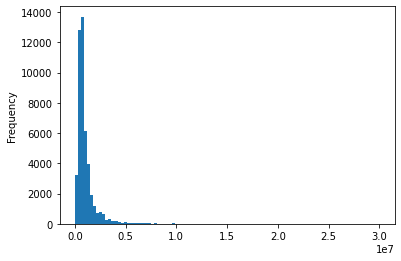

In [29]:
data.price.plot.hist(bins = 100)

In [30]:
data = data[data.price > 20_000]

#### Price per square meter

<AxesSubplot:ylabel='Frequency'>

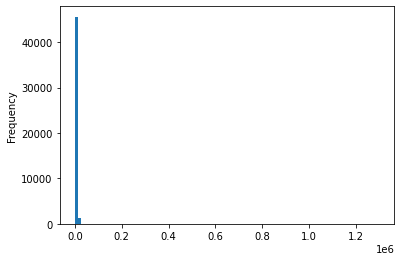

In [31]:
data.price_per_square_meter.plot.hist(bins = 100)

In [32]:
data = data[data.price_per_square_meter > 1_000][data.price_per_square_meter < 70_000]

#### Area

<AxesSubplot:ylabel='Frequency'>

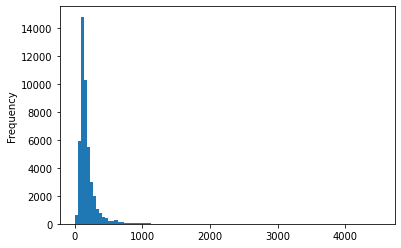

In [33]:
data.area.plot.hist(bins = 100)

In [34]:
data = data[data.area > 10]

#### Rent

<AxesSubplot:ylabel='Frequency'>

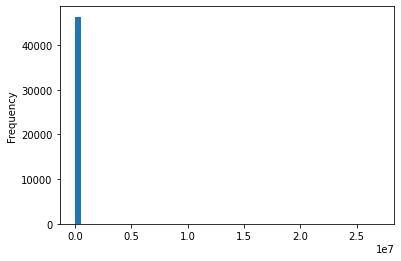

In [35]:
data.rent.plot.hist(bins = 50)

In [36]:
data = data[data.rent < 5000]

#### Number of rooms

<AxesSubplot:ylabel='Frequency'>

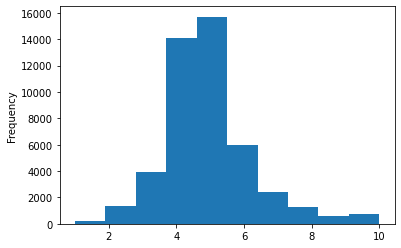

In [37]:
data.number_of_rooms.plot.hist(bins = 10)

#### Land area

<AxesSubplot:ylabel='Frequency'>

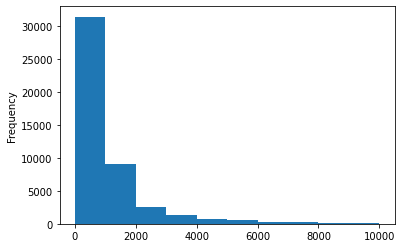

In [38]:
data.land_area.plot.hist(bins = 10)

#### Number of floors

<AxesSubplot:ylabel='Frequency'>

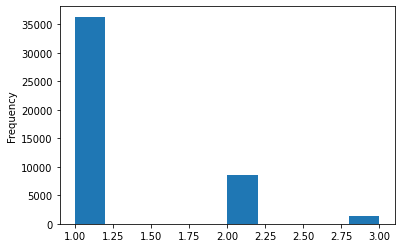

In [39]:
data.number_of_floors.plot.hist(bins = 10)

#### Construction year

<AxesSubplot:ylabel='Frequency'>

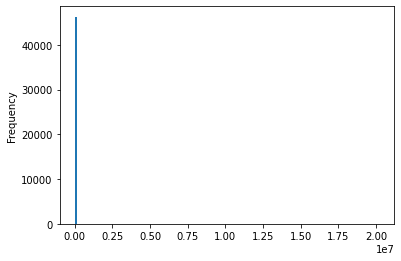

In [40]:
data.construction_year.plot.hist(bins = 150)

In [41]:
data = data[data.construction_year > 1800][data.construction_year < 2030]

#### Time to centre

<AxesSubplot:ylabel='Frequency'>

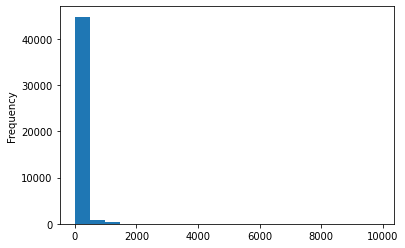

In [42]:
data.time_to_centre.plot.hist(bins = 20)

In [43]:
data = data[data.time_to_centre < 60]

#### Time to the nearest shop

<AxesSubplot:ylabel='Frequency'>

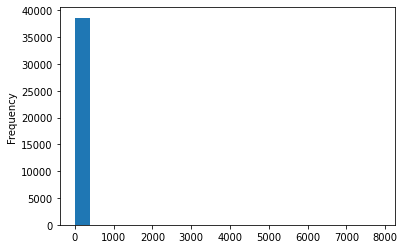

In [44]:
data.time_to_nearest_shop.plot.hist(bins = 20)

In [45]:
data = data[data.time_to_nearest_shop < 60]

#### Time to the nearest shop

<AxesSubplot:ylabel='Frequency'>

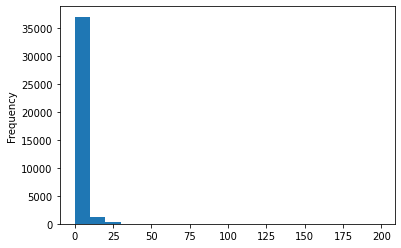

In [46]:
data.time_to_nearest_stop.plot.hist(bins = 20)

In [47]:
data = data[data.time_to_nearest_shop < 60]

In [48]:
data

,price,price_per_square_meter,area,location,heating,land_area,finishing_standard,building_type,construction_year,number_of_rooms,...,time_to_centre,is_lake,is_forest,is_moutain,is_sea,has_parking,is_summer_house,has_security_protection,is_duplex,has_basement
0,80000.0,1143.0,70.00,"Piszewo, warmińsko-mazurskie",0,806.0,1,8,1930,3,...,0.000000,0,0,0,0,1,0,0,0,0
2,800000.0,2000.0,400.00,"Mońki, moniecki, podlaskie",111,1500.0,3,8,1982,7,...,0.000000,0,0,0,0,1,0,0,0,0
3,849600.0,1770.0,480.00,"Mrągowo, warmińsko-mazurskie",1,2300.0,3,8,2017,5,...,0.000000,1,1,0,0,1,0,1,0,1
4,395000.0,3292.0,120.00,"Brzesko, brzeski, małopolskie",0,300.0,1,0,2017,3,...,0.000000,0,0,0,0,1,0,0,0,0
5,680000.0,4000.0,170.00,"Gliwice, Śródmieście",0,665.0,0,0,2017,5,...,3.196667,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47646,1300000.0,5306.0,245.00,"Warszawa, Wawer, Radość",70,300.0,3,0,1990,6,...,22.916667,0,0,0,0,1,0,0,0,0
47647,461000.0,6183.0,74.56,"Czapury, wielkopolskie",0,665.0,2,0,2022,4,...,0.000000,0,0,0,0,1,0,0,0,0
47648,770000.0,5923.0,130.00,"Milanówek, mazowieckie",110,346.0,2,1,2022,5,...,0.000000,0,0,0,0,1,0,1,0,0
47649,739000.0,5503.0,134.28,"Bydgoszcz, Osowa Góra",70,355.0,2,0,2022,5,...,14.493333,0,0,0,0,1,0,0,0,0


#### Population

<AxesSubplot:ylabel='Frequency'>

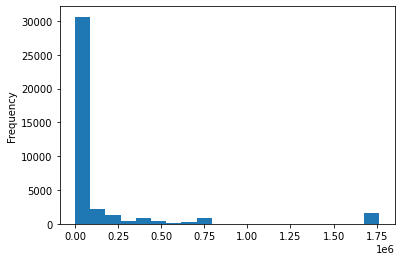

In [49]:
data.population.plot.hist(bins = 20)


In [50]:
data = data[data.population > 0]

In [51]:
data = data.assign(age = 2022 - data.construction_year)

#### Normalization

In [52]:
rent_scaler = preprocessing.MinMaxScaler()
rent_scaler.fit(data[['rent']].to_numpy())
data['rent'] = rent_scaler.fit_transform(data[['rent']].to_numpy())

population_scaler = preprocessing.MinMaxScaler()
population_scaler.fit(data[['population']].to_numpy())
data[['population']] = population_scaler.fit_transform(data[['population']].to_numpy())

age_scaler = preprocessing.MinMaxScaler()
age_scaler.fit(data[['age']].to_numpy())
data['age'] = age_scaler.fit_transform(data[['age']].to_numpy())

area_scaler = preprocessing.MinMaxScaler()
area_scaler.fit(data[['area']].to_numpy())
data[['area']] = area_scaler.fit_transform(data[['area']].to_numpy())

land_area_scaler = preprocessing.MinMaxScaler()
land_area_scaler.fit(data[['land_area']].to_numpy())
data[['land_area']] = land_area_scaler.fit_transform(data[['land_area']].to_numpy())

In [53]:
data

,price,price_per_square_meter,area,location,heating,land_area,finishing_standard,building_type,construction_year,number_of_rooms,...,is_lake,is_forest,is_moutain,is_sea,has_parking,is_summer_house,has_security_protection,is_duplex,has_basement,age
0,80000.0,1143.0,0.012329,"Piszewo, warmińsko-mazurskie",0,0.080615,1,8,1930,3,...,0,0,0,0,1,0,0,0,0,0.424107
2,800000.0,2000.0,0.085903,"Mońki, moniecki, podlaskie",111,0.150029,3,8,1982,7,...,0,0,0,0,1,0,0,0,0,0.191964
3,849600.0,1770.0,0.103739,"Mrągowo, warmińsko-mazurskie",1,0.230045,3,8,2017,5,...,1,1,0,0,1,0,1,0,1,0.035714
4,395000.0,3292.0,0.023477,"Brzesko, brzeski, małopolskie",0,0.030005,1,0,2017,3,...,0,0,0,0,1,0,0,0,0,0.035714
5,680000.0,4000.0,0.034624,"Gliwice, Śródmieście",0,0.066512,0,0,2017,5,...,0,0,0,0,1,0,0,0,0,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47646,1300000.0,5306.0,0.051346,"Warszawa, Wawer, Radość",70,0.030005,3,0,1990,6,...,0,0,0,0,1,0,0,0,0,0.156250
47647,461000.0,6183.0,0.013346,"Czapury, wielkopolskie",0,0.066512,2,0,2022,4,...,0,0,0,0,1,0,0,0,0,0.013393
47648,770000.0,5923.0,0.025706,"Milanówek, mazowieckie",110,0.034606,2,1,2022,5,...,0,0,0,0,1,0,1,0,0,0.013393
47649,739000.0,5503.0,0.026660,"Bydgoszcz, Osowa Góra",70,0.035506,2,0,2022,5,...,0,0,0,0,1,0,0,0,0,0.013393


In [54]:
data.columns

Index(['price', 'price_per_square_meter', 'area', 'location', 'heating',
       'land_area', 'finishing_standard', 'building_type', 'construction_year',
       'number_of_rooms', 'parking', 'rent', 'market', 'number_of_floors',
       'summer_house', 'security', 'surroundings', 'additional_information',
       'state', 'locality', 'population', 'type_of_locality',
       'time_to_nearest_shop', 'time_to_nearest_stop', 'time_to_centre',
       'is_lake', 'is_forest', 'is_moutain', 'is_sea', 'has_parking',
       'is_summer_house', 'has_security_protection', 'is_duplex',
       'has_basement', 'age'],
      dtype='object')

In [55]:
data = data.reset_index(drop = True)

In [56]:
data.head()

,price,price_per_square_meter,area,location,heating,land_area,finishing_standard,building_type,construction_year,number_of_rooms,...,is_lake,is_forest,is_moutain,is_sea,has_parking,is_summer_house,has_security_protection,is_duplex,has_basement,age
0,80000.0,1143.0,0.012329,"Piszewo, warmińsko-mazurskie",0,0.080615,1,8,1930,3,...,0,0,0,0,1,0,0,0,0,0.424107
1,800000.0,2000.0,0.085903,"Mońki, moniecki, podlaskie",111,0.150029,3,8,1982,7,...,0,0,0,0,1,0,0,0,0,0.191964
2,849600.0,1770.0,0.103739,"Mrągowo, warmińsko-mazurskie",1,0.230045,3,8,2017,5,...,1,1,0,0,1,0,1,0,1,0.035714
3,395000.0,3292.0,0.023477,"Brzesko, brzeski, małopolskie",0,0.030005,1,0,2017,3,...,0,0,0,0,1,0,0,0,0,0.035714
4,680000.0,4000.0,0.034624,"Gliwice, Śródmieście",0,0.066512,0,0,2017,5,...,0,0,0,0,1,0,0,0,0,0.035714


In [57]:
columns_to_drop = [
    'surroundings',
    'parking',
    'additional_information',
    'security',
    'location',
    'construction_year',
    'summer_house'
]
data = data.drop(columns=columns_to_drop)

In [58]:
data.describe()

,price,price_per_square_meter,area,heating,land_area,finishing_standard,building_type,number_of_rooms,rent,market,...,is_lake,is_forest,is_moutain,is_sea,has_parking,is_summer_house,has_security_protection,is_duplex,has_basement,age
count,3.848300e+04,38483.000000,38483.000000,38483.000000,38483.000000,38483.000000,38483.000000,38483.000000,38483.000000,38483.000000,...,38483.000000,38483.000000,38483.000000,38483.000000,38483.000000,38483.000000,38483.000000,38483.000000,38483.000000,38483.000000
mean,1.094718e+06,5872.880285,0.039152,50.975678,0.103778,1.909934,5.160434,4.899696,0.075358,0.691240,...,0.077203,0.224930,0.019983,0.008991,0.998935,0.010446,0.356885,0.000260,0.169244,0.080975
std,1.244062e+06,3137.832661,0.036702,46.564392,0.130172,1.332723,3.468238,1.479349,0.013930,0.476333,...,0.266917,0.417542,0.139943,0.094395,0.032624,0.101673,0.479087,0.016118,0.374972,0.109068
min,4.400000e+04,1004.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.500000e+05,3883.000000,0.022362,0.000000,0.035706,1.000000,1.000000,4.000000,0.074998,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.013393
50%,7.800000e+05,5385.000000,0.030165,70.000000,0.066512,2.000000,8.000000,5.000000,0.074998,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.035714
75%,1.200000e+06,7119.500000,0.043765,86.000000,0.110571,3.000000,8.000000,5.000000,0.074998,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.098214
max,3.000000e+07,68286.000000,1.000000,168.000000,1.000000,6.000000,9.000000,10.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
data.dtypes

price                      float64
price_per_square_meter     float64
area                       float64
heating                      int64
land_area                  float64
finishing_standard           int64
building_type                int64
number_of_rooms              Int64
rent                       float64
market                       int64
number_of_floors           float64
state                        int64
locality                     int64
population                 float64
type_of_locality             int64
time_to_nearest_shop       float64
time_to_nearest_stop       float64
time_to_centre             float64
is_lake                      int64
is_forest                    int64
is_moutain                   int64
is_sea                       int64
has_parking                  int64
is_summer_house              int64
has_security_protection      int64
is_duplex                    int64
has_basement                 int64
age                        float64
dtype: object

In [60]:
data.isna().sum()

price                      0
price_per_square_meter     0
area                       0
heating                    0
land_area                  0
finishing_standard         0
building_type              0
number_of_rooms            0
rent                       0
market                     0
number_of_floors           0
state                      0
locality                   0
population                 0
type_of_locality           0
time_to_nearest_shop       0
time_to_nearest_stop       0
time_to_centre             0
is_lake                    0
is_forest                  0
is_moutain                 0
is_sea                     0
has_parking                0
is_summer_house            0
has_security_protection    0
is_duplex                  0
has_basement               0
age                        0
dtype: int64

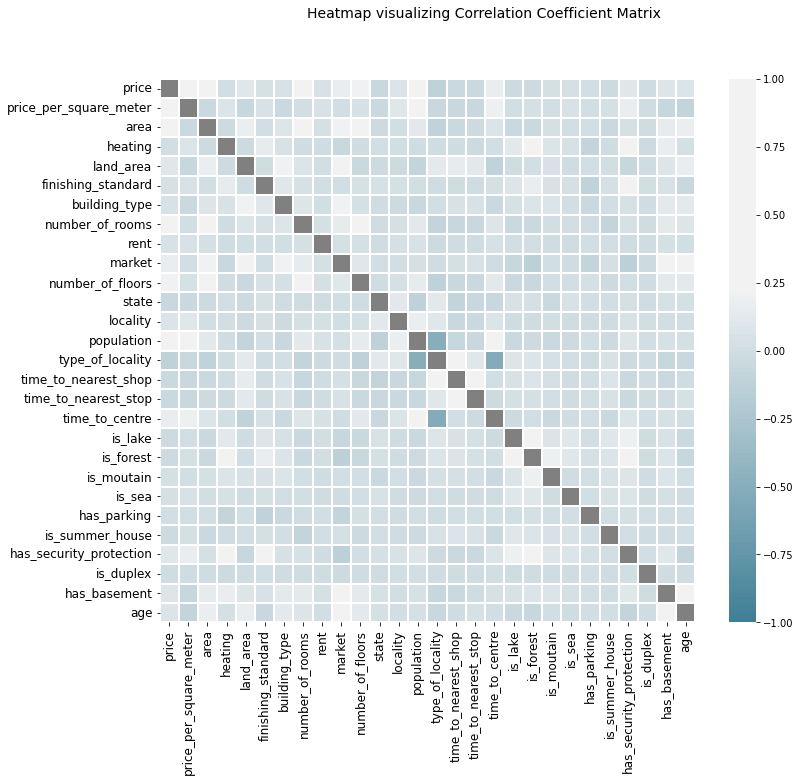

In [61]:
corr = data.corr()
  
masking = np.zeros_like(corr, dtype = np.bool)  
np.fill_diagonal(masking, val = True)  
  
figure, axis = plt.subplots(figsize = (12, 10))  
  
c_map = sns.diverging_palette(223, 14, as_cmap = True, sep = 100)  
c_map.set_bad('grey')  
  
sns.heatmap(corr, mask = masking, cmap = c_map, vmin = -1, vmax = 1, center = 1, linewidths = 1)  
figure.suptitle('Heatmap visualizing Correlation Coefficient Matrix', fontsize = 14)  
axis.tick_params(axis = 'both', which = 'major', labelsize = 12)  

In [62]:
data.to_csv('./preprocessed_dataset_houses.csv')

In [63]:
joblib.dump(rent_scaler, "rent_scaler_houses.save") 

joblib.dump(population_scaler, "population_scaler_houses.save")

joblib.dump(age_scaler, "age_scaler_houses.save")

joblib.dump(area_scaler, "area_scaler_houses.save")

joblib.dump(area_scaler, "land_area_scaler_houses.save")

joblib.dump(le_finishing_standard, "le_finishing_houses.save")

joblib.dump(le_heating, "le_heating_houses.save")

joblib.dump(le_building_type, "le_building_type_houses.save")

joblib.dump(le_market, "le_market_houses.save")

joblib.dump(le_state, "le_state_houses.save")

joblib.dump(le_locality, "le_locality_houses.save")

joblib.dump(le_locality, "le_locality_houses.save")

joblib.dump(le_locality_type, "le_locality_type_houses.save")

['le_locality_type_houses.save']